In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
!pip install tf-models-official
from official import nlp
import official.nlp.optimization
from tensorflow import keras
from tensorflow.keras import layers
# import import_ipynb
# from custom_matching_layers import *
from sklearn.model_selection import train_test_split
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [ ]:
print(os.listdir("./datasets"))
print(os.listdir("./datasets/MSRP"))

['MSRP', 'SICK', 'QQP']
['msrp_test.txt', 'msrp_train.txt', 'msrptrain.csv', 'msrp.csv', 'msrptest.csv', 'MSRParaphraseCorpus.msi']


In [ ]:
df_qqp = pd.read_csv('/content/drive/MyDrive/PD/msrp.csv')

In [ ]:
df_qqp

,id,qid1,qid2,question1,question2,is_duplicate
0,0,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1
1,1,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0
2,2,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1
3,3,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0
4,4,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1
...,...,...,...,...,...,...
5796,5796,2685984,2686122,"After Hughes refused to rehire Hernandez , he ...",Hernandez filed an Equal Employment Opportunit...,0
5797,5797,339215,339172,There are 103 Democrats in the Assembly and 47...,Democrats dominate the Assembly while Republic...,0
5798,5798,2996850,2996734,Bethany Hamilton remained in stable condition ...,"Bethany , who remained in stable condition aft...",0
5799,5799,2095781,2095812,"Last week the power station ’ s US owners , AE...","The news comes after Drax 's American owner , ...",1


In [ ]:
print(type(df_qqp['question1']))


<class 'pandas.core.series.Series'>


In [ ]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def text_to_word_list(text, remove_stop_words=False):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    
    if remove_stop_words:
        text = [wd for wd in text if wd not in stops]

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
text_to_word_list('step by step')

['step', 'by', 'step']

In [ ]:
s1 = {"Harry Potter defeated Voldemort"}
s2 = ["Voldemort was defeated by Harry Potter"]

pdd['question1'] = s1.map(lambda x: text_to_word_list(x))
pdd['question2'] = s2.map(lambda x: text_to_word_list(x))
pdd['len_q1'] = s1.map(lambda x: len(x))
pdd['len_q2'] = s2.map(lambda x: len(x))

AttributeError: ignored

In [ ]:
print(df_qqp['question1'])
df_qqp['question1'] = df_qqp['question1'].map(lambda x: text_to_word_list(x))
df_qqp['question2'] = df_qqp['question2'].map(lambda x: text_to_word_list(x))
df_qqp['len_q1'] = df_qqp['question1'].map(lambda x: len(x))
df_qqp['len_q2'] = df_qqp['question2'].map(lambda x: len(x))

0       [amrozi, accused, his, brother, whom, he, call...
1       [yucaipa, owned, dominick, before, selling, th...
2       [they, had, published, an, advertisement, on, ...
3       [around, 0335, gmt, tab, shares, were, up, 19,...
4       [the, stock, rose, 2, 11, or, about, 11, perce...
                              ...                        
5796    [after, hughes, refused, to, rehire, hernandez...
5797    [there, are, 103, democrats, in, the, assembly...
5798    [bethany, hamilton, remained, in, stable, cond...
5799    [last, week, the, power, station, s, us, owner...
5800    [sobig, f, spreads, when, unsuspecting, comput...
Name: question1, Length: 5801, dtype: object


In [ ]:
df_qqp.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21


In [ ]:
df_qqp.describe()

,id,qid1,qid2,is_duplicate,len_q1,len_q2
count,5801.000000,5.801000e+03,5.801000e+03,5801.000000,5801.000000,5801.000000
mean,2900.000000,1.684367e+06,1.684367e+06,0.672298,19.889502,19.839683
std,1674.748787,9.916988e+05,9.917017e+05,0.469416,5.457898,5.471728
min,0.000000,2.670000e+02,1.400000e+02,0.000000,6.000000,5.000000
25%,1450.000000,8.068650e+05,8.068650e+05,0.000000,16.000000,16.000000
50%,2900.000000,1.691429e+06,1.691465e+06,1.000000,20.000000,20.000000
75%,4350.000000,2.537987e+06,2.538021e+06,1.000000,24.000000,24.000000
max,5800.000000,3.464314e+06,3.464302e+06,1.000000,39.000000,39.000000


In [ ]:
sentence_len = 40
max_sentence_length = sentence_len
embeddings_len = 300
max_unique_words = 20000

In [ ]:
temp = df_qqp[(df_qqp['len_q1']<sentence_len) & (df_qqp['len_q2']<sentence_len)]
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21
...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"[after, hughes, refused, to, rehire, hernandez...","[hernandez, filed, an, equal, employment, oppo...",0,14,10
5797,5797,339215,339172,"[there, are, 103, democrats, in, the, assembly...","[democrats, dominate, the, assembly, while, re...",0,10,9
5798,5798,2996850,2996734,"[bethany, hamilton, remained, in, stable, cond...","[bethany, who, remained, in, stable, condition...",0,12,16
5799,5799,2095781,2095812,"[last, week, the, power, station, s, us, owner...","[the, news, comes, after, drax, american, owne...",1,26,28


In [ ]:
all_questions = list(temp['question1'].values) + list(temp['question2'].values)

In [ ]:
# glove_embeddings = {}
# with open('8/model.txt') as f:
#     for line in f:
#         word, coefs = line.split(maxsplit=1)
#         coefs = np.fromstring(coefs, "f", sep=" ")
#         glove_embeddings[word.lower()] = coefs

# print("Found %s word vectors." % len(glove_embeddings))

glove_embeddings = {}
with open('/content/drive/MyDrive/PD/glove.6B.300d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word.lower()] = coefs

print("Found %s word vectors." % len(glove_embeddings))

Found 400000 word vectors.


In [ ]:
len(glove_embeddings.keys())

400000

In [ ]:
word_to_index = dict()
index_to_word = ['<pad>','unk']
word_to_index['unk'] = 1
questions_cols = ['question1', 'question2']
q1_indexes = []
q2_indexes = []
hits = 0
misses = 0
for index, row in tqdm(temp.iterrows()):
    for question in questions_cols:
        q2n = []
        for word in row[question]:
            if word not in glove_embeddings:
                misses+=1
                word = 'unk'
            else:
                hits+=1
            if word not in word_to_index:
                word_to_index[word] = len(index_to_word)
                q2n.append(len(index_to_word))
                index_to_word.append(word)
            else:
                q2n.append(word_to_index[word])
        if question == 'question1':
            q1_indexes.append(q2n)
        else:
            q2_indexes.append(q2n)
print(hits,misses)
temp['q1_indexes'] = q1_indexes
temp['q2_indexes'] = q2_indexes

5801it [00:00, 7029.27it/s]

229616 853


In [ ]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 14]","[15, 16, 17, 18, 19, 9, 10, 2, 3, 4, 5, 11, 12..."
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19,"[20, 21, 22, 23, 24, 9, 25, 16, 26, 27, 28, 29...","[20, 33, 22, 27, 34, 29, 35, 36, 37, 38, 39, 1..."
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18,"[42, 43, 44, 45, 46, 47, 9, 48, 47, 49, 50, 51...","[47, 49, 50, 9, 55, 56, 43, 44, 45, 46, 47, 9,..."
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18,"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...","[61, 62, 78, 79, 66, 67, 68, 80, 16, 74, 70, 7..."
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21,"[9, 82, 83, 30, 84, 67, 85, 84, 86, 16, 87, 88...","[94, 95, 96, 62, 78, 40, 97, 67, 41, 86, 16, 8..."
...,...,...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"[after, hughes, refused, to, rehire, hernandez...","[hernandez, filed, an, equal, employment, oppo...",0,14,10,"[466, 1753, 2131, 16, 10496, 2372, 7, 15176, 1...","[2372, 574, 45, 1830, 5262, 2175, 653, 4930, 3..."
5797,5797,339215,339172,"[there, are, 103, democrats, in, the, assembly...","[democrats, dominate, the, assembly, while, re...",0,10,9,"[559, 487, 3822, 1864, 27, 9, 4849, 37, 1352, ...","[1864, 15177, 9, 4849, 181, 1863, 1665, 9, 3000]"
5798,5798,2996850,2996734,"[bethany, hamilton, remained, in, stable, cond...","[bethany, who, remained, in, stable, condition...",0,12,16,"[10364, 1062, 2337, 27, 1735, 2316, 1780, 466,...","[10364, 611, 2337, 27, 1735, 2316, 466, 9, 125..."
5799,5799,2095781,2095812,"[last, week, the, power, station, s, us, owner...","[the, news, comes, after, drax, american, owne...",1,26,28,"[505, 976, 9, 985, 473, 139, 632, 56, 9596, 96...","[9, 685, 853, 466, 7137, 488, 9595, 9596, 96, ..."


In [ ]:
len(word_to_index)

15177

In [ ]:
num_tokens = len(word_to_index) + 2
embedding_matrix = np.zeros((num_tokens, embeddings_len))
for word, i in word_to_index.items():
    embedding_matrix[i] = glove_embeddings[word]

In [ ]:
# temp = temp[temp['q1_indexes'].map(lambda x:len(x))<max_sentence_length]
# temp = temp[temp['q2_indexes'].map(lambda x:len(x))<max_sentence_length]
temp.loc[:,'l'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q1_indexes'], maxlen=max_sentence_length)),index=temp.index)
temp.loc[:,'r'] = pd.Series(list(keras.preprocessing.sequence.pad_sequences(temp['q2_indexes'], maxlen=max_sentence_length)),index=temp.index)

In [ ]:
temp

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,q1_indexes,q2_indexes,l,r
0,0,702876,702977,"[amrozi, accused, his, brother, whom, he, call...","[referring, to, him, as, only, the, witness, a...",1,14,16,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 14]","[15, 16, 17, 18, 19, 9, 10, 2, 3, 4, 5, 11, 12...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,2108705,2108831,"[yucaipa, owned, dominick, before, selling, th...","[yucaipa, bought, dominick, in, 1995, for, 693...",0,15,19,"[20, 21, 22, 23, 24, 9, 25, 16, 26, 27, 28, 29...","[20, 33, 22, 27, 34, 29, 35, 36, 37, 38, 39, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,1330381,1330521,"[they, had, published, an, advertisement, on, ...","[on, june, 10, the, ship, owners, had, publish...",1,18,18,"[42, 43, 44, 45, 46, 47, 9, 48, 47, 49, 50, 51...","[47, 49, 50, 9, 55, 56, 43, 44, 45, 46, 47, 9,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,3344667,3344648,"[around, 0335, gmt, tab, shares, were, up, 19,...","[tab, shares, jumped, 20, cents, or, 4, 6, to,...",0,26,18,"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...","[61, 62, 78, 79, 66, 67, 68, 80, 16, 74, 70, 7...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 58,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,1236820,1236712,"[the, stock, rose, 2, 11, or, about, 11, perce...","[pg, e, corp, shares, jumped, 1, 63, or, 8, pe...",1,21,21,"[9, 82, 83, 30, 84, 67, 85, 84, 86, 16, 87, 88...","[94, 95, 96, 62, 78, 40, 97, 67, 41, 86, 16, 8...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
5796,5796,2685984,2686122,"[after, hughes, refused, to, rehire, hernandez...","[hernandez, filed, an, equal, employment, oppo...",0,14,10,"[466, 1753, 2131, 16, 10496, 2372, 7, 15176, 1...","[2372, 574, 45, 1830, 5262, 2175, 653, 4930, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5797,5797,339215,339172,"[there, are, 103, democrats, in, the, assembly...","[democrats, dominate, the, assembly, while, re...",0,10,9,"[559, 487, 3822, 1864, 27, 9, 4849, 37, 1352, ...","[1864, 15177, 9, 4849, 181, 1863, 1665, 9, 3000]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5798,5798,2996850,2996734,"[bethany, hamilton, remained, in, stable, cond...","[bethany, who, remained, in, stable, condition...",0,12,16,"[10364, 1062, 2337, 27, 1735, 2316, 1780, 466,...","[10364, 611, 2337, 27, 1735, 2316, 466, 9, 125...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5799,5799,2095781,2095812,"[last, week, the, power, station, s, us, owner...","[the, news, comes, after, drax, american, owne...",1,26,28,"[505, 976, 9, 985, 473, 139, 632, 56, 9596, 96...","[9, 685, 853, 466, 7137, 488, 9595, 9596, 96, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 505...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 685, 8..."


In [ ]:
X_l = np.stack(temp['l'].to_numpy(),axis=1).T
X_r = np.stack(temp['r'].to_numpy(),axis=1).T
X = np.stack([X_l,X_r],axis=1)
print(X)
# X = np.stack(temp['l'].to_numpy(),axis=1).T
Y = np.stack(temp['is_duplicate'].to_numpy())
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)

[[[   0    0    0 ...   13    4   14]
  [   0    0    0 ...   13    4   14]]

 [[   0    0    0 ...   30   31   32]
  [   0    0    0 ...   32   27   28]]

 [[   0    0    0 ...   53    7   54]
  [   0    0    0 ...   57   29   53]]

 ...

 [[   0    0    0 ... 1258   88  728]
  [   0    0    0 ...    9 1258 1780]]

 [[   0    0    0 ... 1167 9597  708]
  [   0    0    0 ...  669 9597  708]]

 [[   0    0    0 ...  684  136 2954]
  [   0    0    0 ...  943  684  658]]]


In [ ]:
temp.iloc[0]

id                                                              0
qid1                                                       702876
qid2                                                       702977
question1       [amrozi, accused, his, brother, whom, he, call...
question2       [referring, to, him, as, only, the, witness, a...
is_duplicate                                                    1
len_q1                                                         14
len_q2                                                         16
q1_indexes        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 4, 14]
q2_indexes      [15, 16, 17, 18, 19, 9, 10, 2, 3, 4, 5, 11, 12...
l               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
r               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object

In [ ]:
temp.iloc[0]['l']

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13,  4, 14], dtype=int32)

In [ ]:
embedding_matrix[1]

array([ 3.00709993e-01, -4.68670011e-01, -2.06169993e-01, -8.09780002e-01,
       -2.38890007e-01,  2.43290007e-01,  1.65379997e-02, -3.56869996e-02,
       -2.23059997e-01,  9.51889992e-01, -3.22730005e-01,  2.19799995e-01,
       -6.75240010e-02, -3.72200012e-01, -3.97179991e-01, -4.38609987e-01,
        1.19670004e-01, -2.99640000e-01,  2.84369998e-02, -8.75440016e-02,
        1.65690005e-01, -4.94509995e-01, -6.20109975e-01, -1.65739998e-01,
       -9.72179994e-02, -9.94739980e-02, -8.03069994e-02, -3.93379986e-01,
       -2.41950005e-01,  3.20230007e-01, -5.33200026e-01, -4.01840001e-01,
       -6.71350002e-01, -7.85610005e-02,  5.55459976e-01,  2.99970001e-01,
       -9.96500030e-02, -6.70350015e-01,  1.26690000e-01, -1.86179996e-01,
       -6.26209974e-02,  4.52899992e-01,  3.92650008e-01,  2.41209999e-01,
       -4.14739996e-01, -6.18900001e-01, -1.04120001e-01, -3.10429990e-01,
       -6.67880010e-03, -8.32480013e-01,  6.51499987e-01,  9.01809990e-01,
        2.41459999e-02, -

In [ ]:
embedding_matrix.shape

(15179, 300)

## Building Model

In [ ]:
embedding_layer = layers.Embedding(
    num_tokens,
    embeddings_len,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
left_input = layers.Input(shape=(max_sentence_length,), dtype='int32')
right_input = layers.Input(shape=(max_sentence_length,), dtype='int32')

In [ ]:
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

In [ ]:
lstm_dim = 64
forward_layer = layers.LSTM(lstm_dim, return_sequences=True, return_state=True, dropout=0.1)
backward_layer = layers.LSTM(lstm_dim, return_sequences=True, return_state=True, go_backwards=True, dropout=0.1)

In [ ]:
forward_left, forward_left_final, _ = forward_layer(encoded_left)
forward_right, forward_right_final, _ = forward_layer(encoded_right)
backward_left, backward_left_final, _ = backward_layer(encoded_left)
backward_left = keras.backend.reverse(backward_left,axes=-2)
backward_right, backward_right_final, _ = backward_layer(encoded_right)
backward_right = keras.backend.reverse(backward_right,axes=-2)

In [ ]:
perspectives = 20

In [ ]:
class matching_1(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_1, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(inputs[1], axis=-2) # b,1,d
        right = tf.math.multiply(self.w,right) # b,p,d
        matching = layers.Dot(axes=(3, 2),normalize=True)([left,right]) #b,s,p,p
        matching = tf.linalg.diag_part(matching) #b,s,p
        return matching

In [ ]:
class matching_2(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_2, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )

    @tf.function
    def call(self, inputs, **kwargs):
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(inputs[1], axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        matching = layers.Dot(axes=(3, 3),normalize=True)([left,right]) #b,s,p,s,p
        matching = tf.reduce_max(matching,axis=3)
        matching = tf.linalg.diag_part(matching) #b,s,p
        return matching

In [ ]:
class matching_3(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_3, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.sentence_length = input_shape[0][1]

    @tf.function
    def call(self, inputs, **kwargs):      
        aij = layers.Dot(axes=(2,2),normalize=True)([inputs[0],inputs[1]]) # b,s,s
        weighted_right = tf.einsum('bsk,bkd->bsd', aij, inputs[1]) # b,s,d
        normal = tf.reduce_sum(aij,2,keepdims=True) # b,s,1
        right = weighted_right/normal # b,s,d
        
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(right, axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        
        matching = []
        for sentence in range(self.sentence_length):
            left_sentence = left[:,sentence,:,:] #b,p,d
            right_mean = right[:,sentence,:,:] #b,p,d
            match = layers.Dot(axes=(2, 2),normalize=True)([left_sentence,right_mean]) #b,p,p
            match = tf.linalg.diag_part(match)
            matching.append(match)
        matching = tf.stack(matching,axis=1)
        return matching

In [ ]:
class matching_4(layers.Layer):
    def __init__(self, units=perspectives):
        super(matching_4, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(self.units,input_shape[0][-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.sentence_length = input_shape[0][1]

    @tf.function
    def call(self, inputs, **kwargs):
        
        aij = layers.Dot(axes=(2,2),normalize=True)([inputs[0],inputs[1]]) # b,s,s
        argmax_aij = tf.math.argmax(aij,2) # b,s
        right = tf.gather(inputs[1],argmax_aij,axis=1,batch_dims=1) # b,s,d
        
        left = tf.expand_dims(inputs[0], axis=-2) # b,s,1,d
        left = tf.math.multiply(self.w,left) # b,s,p,d
        right = tf.expand_dims(right, axis=-2) # b,s,1,d
        right = tf.math.multiply(self.w,right) # b,s,p,d
        
        matching = []
        for sentence in range(self.sentence_length):
            left_sentence = left[:,sentence,:,:] #b,p,d
            right_mean = right[:,sentence,:,:] #b,p,d
            match = layers.Dot(axes=(2, 2),normalize=True)([left_sentence,right_mean]) #b,p,p
            match = tf.linalg.diag_part(match)
            matching.append(match)
        matching = tf.stack(matching,axis=1)
        return matching

In [ ]:
forward_matching_1 = matching_1()
backward_matching_1 = matching_1()

match_1_forward_pq = forward_matching_1([forward_left,forward_right_final])
match_1_forward_qp = forward_matching_1([forward_right,forward_left_final])
match_1_backward_pq = backward_matching_1([backward_left,backward_right_final])
match_1_backward_qp = backward_matching_1([backward_right,backward_left_final])
match_1_pq = layers.Concatenate(axis=2)([match_1_forward_pq,match_1_backward_pq])
match_1_qp = layers.Concatenate(axis=2)([match_1_forward_qp,match_1_backward_qp])

forward_matching_2 = matching_2()
backward_matching_2 = matching_2()
match_2_forward_pq = forward_matching_2([forward_left,forward_right])
match_2_forward_qp = forward_matching_2([forward_right,forward_left])
match_2_backward_pq = backward_matching_2([backward_left,backward_right])
match_2_backward_qp = backward_matching_2([backward_right,backward_left])
match_2_pq = layers.Concatenate(axis=2)([match_2_forward_pq,match_2_backward_pq])
match_2_qp = layers.Concatenate(axis=2)([match_2_forward_qp,match_2_backward_qp])

forward_matching_3 = matching_3()
backward_matching_3 = matching_3()
match_3_forward_pq = forward_matching_3([forward_left,forward_right])
match_3_forward_qp = forward_matching_3([forward_right,forward_left])
match_3_backward_pq = backward_matching_3([backward_left,backward_right])
match_3_backward_qp = backward_matching_3([backward_right,backward_left])
match_3_pq = layers.Concatenate(axis=2)([match_3_forward_pq,match_3_backward_pq])
match_3_qp = layers.Concatenate(axis=2)([match_3_forward_qp,match_3_backward_qp])

forward_matching_4 = matching_4()
backward_matching_4 = matching_4()
match_4_forward_pq = forward_matching_4([forward_left,forward_right])
match_4_forward_qp = forward_matching_4([forward_right,forward_left])
match_4_backward_pq = backward_matching_4([backward_left,backward_right])
match_4_backward_qp = backward_matching_4([backward_right,backward_left])
match_4_pq = layers.Concatenate(axis=2)([match_4_forward_pq,match_4_backward_pq])
match_4_qp = layers.Concatenate(axis=2)([match_4_forward_qp,match_4_backward_qp])

In [ ]:
# all_matching_p = layers.Concatenate(axis=2)([match_1_pq,match_2_pq,match_3_pq,match_4_pq])
all_matching_p = layers.Concatenate(axis=2)([match_1_pq,match_2_pq,match_4_pq])
# all_matching_q = layers.Concatenate(axis=2)([match_1_qp,match_2_qp,match_3_qp,match_4_qp])
all_matching_q = layers.Concatenate(axis=2)([match_1_qp,match_2_qp,match_4_qp])
aggregate = layers.Bidirectional(layers.LSTM(64,dropout=0.1))
# aggregate_p = aggregate(all_matching_p)
aggregate_p = aggregate(all_matching_p)
aggregate_q = aggregate(all_matching_q)
# aggregate_q = aggregate(all_matching_q)
concated = layers.Concatenate(axis=1)([aggregate_p,aggregate_q])
x = layers.Dense(128,activation='relu')(concated)
x = layers.Dropout(.1)(x)
x = layers.Dense(64,activation='relu')(x)
x = layers.Dropout(.1)(x)
# x = layers.Dense(64,activation='relu')(x)
final_output = layers.Dense(2,activation="softmax")(x)

In [ ]:
model = keras.Model(inputs=[left_input,right_input], outputs=final_output
                    , name="BiMPM_model")
model.summary()

Model: "BiMPM_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 300)      4553700     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 40, 64), (No 93440       embedding[0][0]        

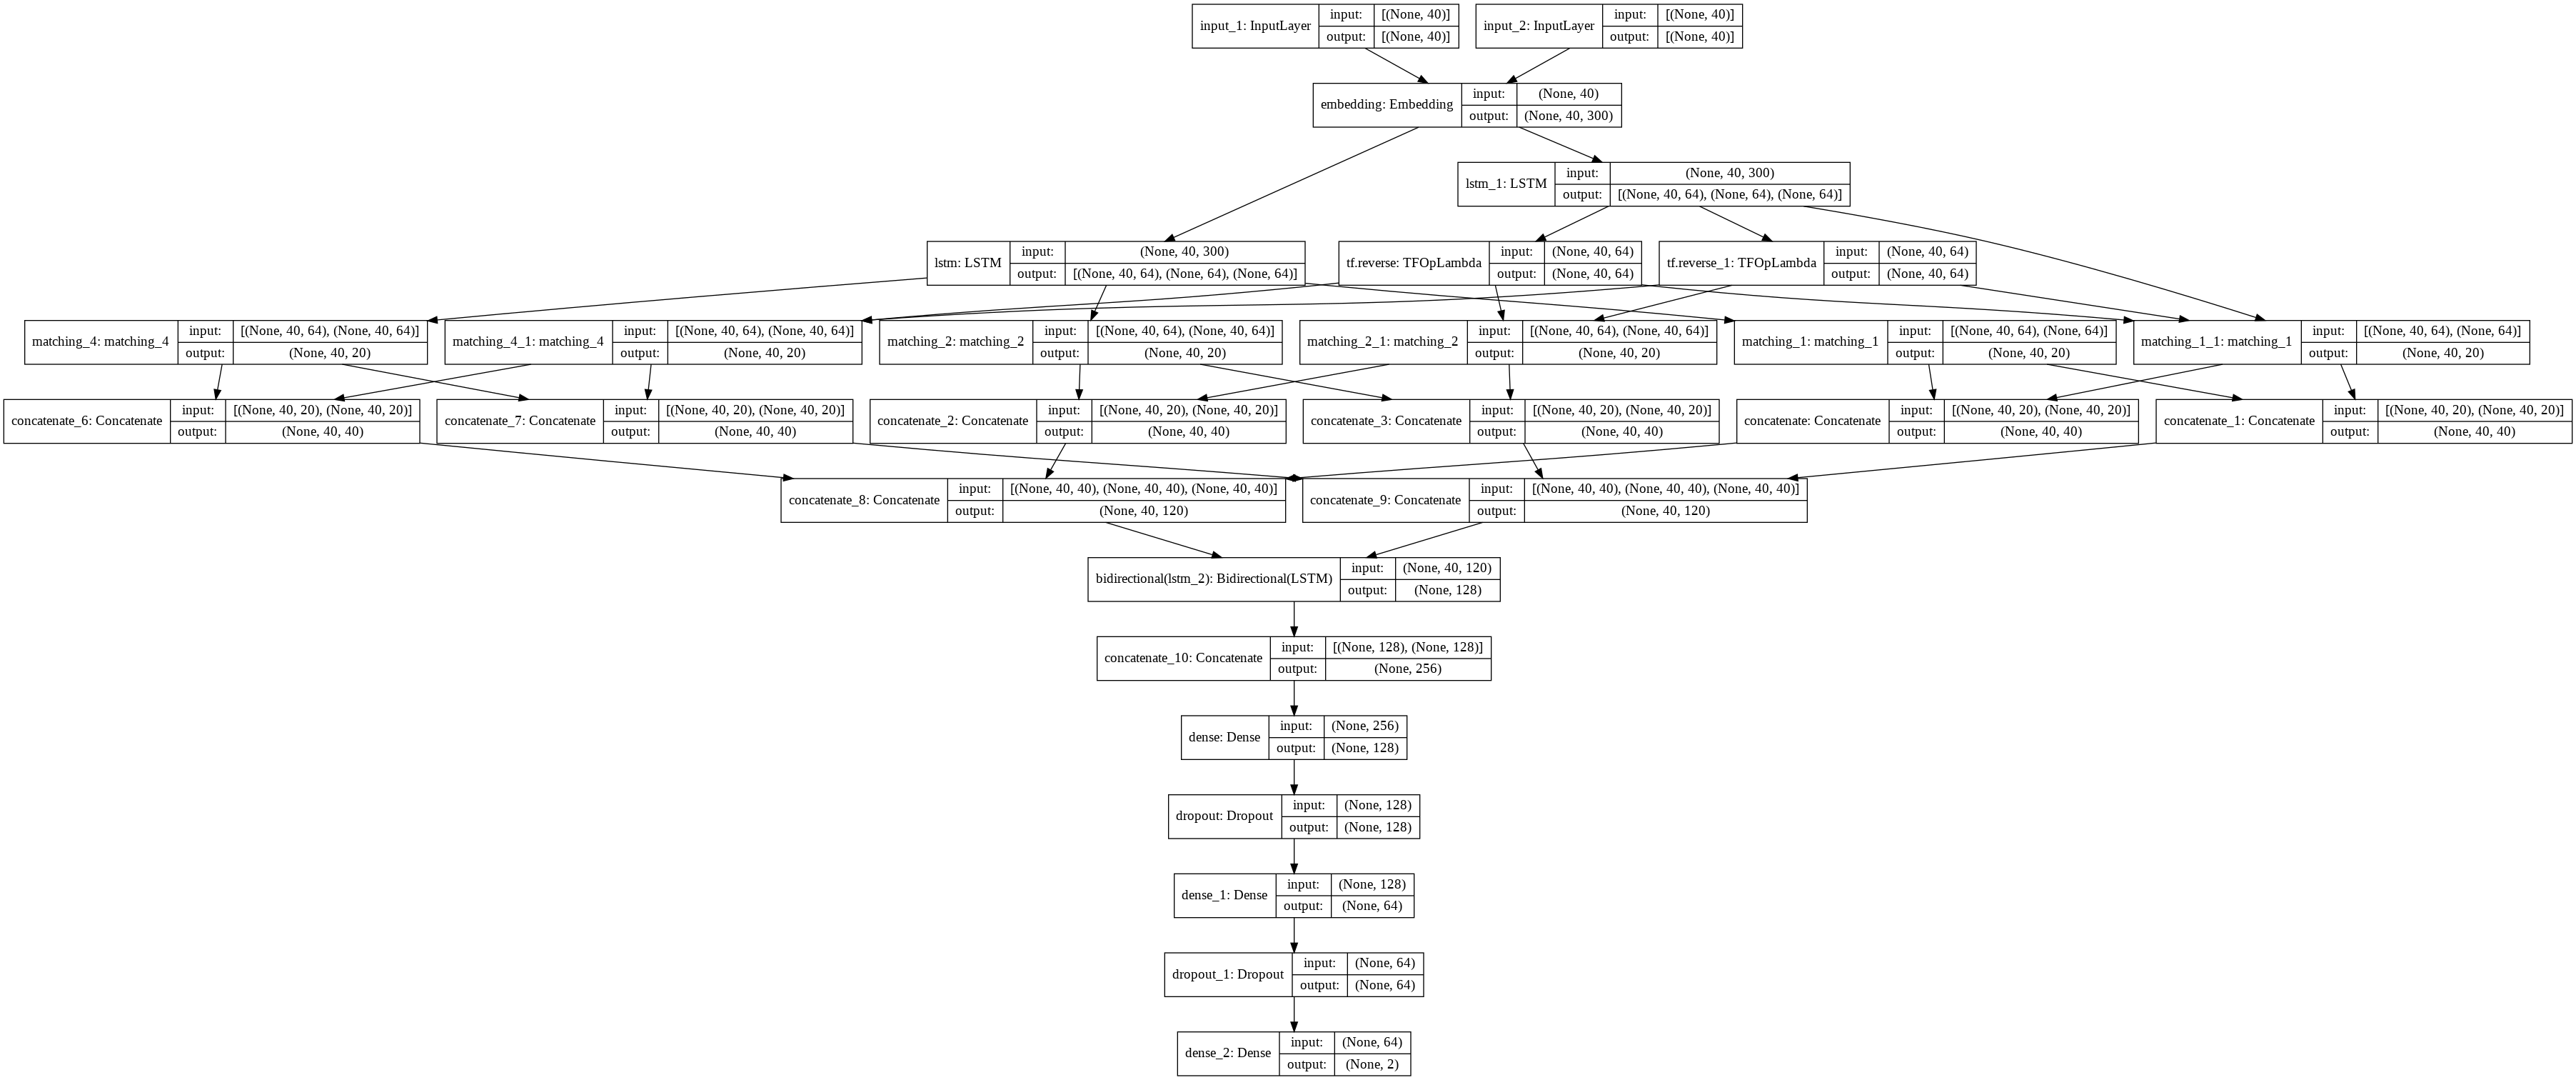

In [ ]:
keras.utils.plot_model(model, "BiMPM.png", show_shapes=True)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer='adam',
    loss=loss,
    metrics=metrics)

In [ ]:
# model.compile(loss='SparseCategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=16, epochs=3,
                            validation_data=([X_validation[:,0], X_validation[:,1]], Y_validation))

Epoch 1/3
290/290 [==============================] - 438s 1s/step - loss: 0.6219 - accuracy: 0.6676 - val_loss: 0.5610 - val_accuracy: 0.7218
Epoch 2/3
290/290 [==============================] - 391s 1s/step - loss: 0.5608 - accuracy: 0.7212 - val_loss: 0.5601 - val_accuracy: 0.7356
Epoch 3/3
290/290 [==============================] - 398s 1s/step - loss: 0.4923 - accuracy: 0.7724 - val_loss: 0.5499 - val_accuracy: 0.7244


In [ ]:
print(X_train[:,0])

[[    0     0     0 ...   726  8926 10931]
 [    0     0     0 ...  1678    16  2182]
 [    0     0     0 ...    37  8385  8386]
 ...
 [    0     0     0 ...  2675     1  2676]
 [    0     0     0 ...  1700    11  1294]
 [    0     0     0 ...   105     9  3023]]


In [ ]:
clf = model.fit([X_train[:,0], X_train[:,1]], Y_train, batch_size=16, epochs=3)

Epoch 1/3
290/290 [==============================] - 374s 1s/step - loss: 0.4303 - accuracy: 0.8097
Epoch 2/3
290/290 [==============================] - 374s 1s/step - loss: 0.3700 - accuracy: 0.8427
Epoch 3/3
290/290 [==============================] - 377s 1s/step - loss: 0.2953 - accuracy: 0.8823


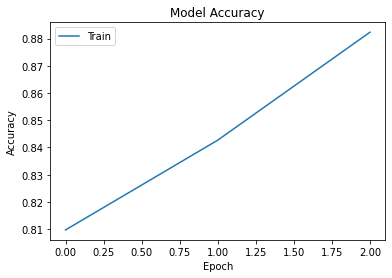

In [ ]:
plt.plot(clf.history['accuracy'])
# plt.plot(clf.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


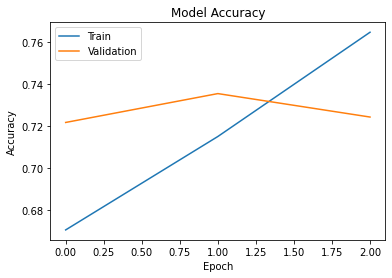

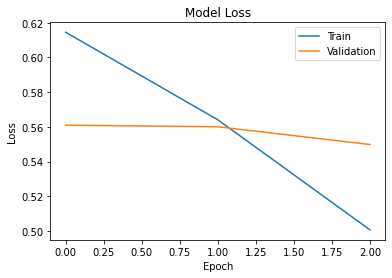

In [ ]:
# Plot accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.save_weights("/content/drive/MyDrive/PD/ress",save_format="h5")

In [ ]:
with open('/content/drive/MyDrive/PD/ress.json', 'w') as f:
    json.dump(hist.history, f)

In [ ]:
s1 = {"Harry Potter defeated Voldemort"}
s2 = {"Voldemort was defeated by Harry Potter"}
y = model.fit([s1,s2])

ValueError: ignored

In [ ]:
clf = model.predict([X_validation[:,0], X_validation[:,1]]) 

In [ ]:
print(clf)

[[2.5756773e-01 7.4243230e-01]
 [8.1026532e-02 9.1897351e-01]
 [2.9539507e-02 9.7046047e-01]
 ...
 [9.6338708e-03 9.9036610e-01]
 [9.9950254e-01 4.9740286e-04]
 [1.0596128e-01 8.9403874e-01]]


In [ ]:
print((X_validation[0,1]))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  325 4472  449
    9 2499   37  342 1177 2643    9 2499   63 5278  380 1738]


In [ ]:
print(len(clf))

1161
